### H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001)

We illustrate the program with the driven and damped qubit example studied in - H. M. Wiseman and L. Diósi, Chemical Physics 268, 91 (2001).

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.insert(1,'../../')
import q_trajectories as qtr

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [10,5]

%load_ext autotime
%load_ext line_profiler

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
time: 22.1 ms


In [10]:
def rhoBlochrep(rho, timeList, method_label, line = '--'):
    t_steps = len(rho)
    t = np.linspace(timeList[0], timeList[-1], t_steps)
    rx = []
    ry = []
    rz = []
    for i in range(t_steps):
        rx.append(np.real(np.trace(rho[i].dot(np.array([[0,1],[1,0]])))))
        ry.append(np.real(np.trace(rho[i].dot(np.array([[0,-1j],[1j,0]])))))
        rz.append(np.real(np.trace(rho[i].dot(np.array([[1,0],[0,-1]])))))

    plt.plot(t, rx, line, label='rx ' + str(method_label), color = "g")
    plt.plot(t, ry, line, label='ry ' + str(method_label), color = "b")
    plt.plot(t, rz, line, label='rz ' + str(method_label), color = "r")

    plt.xlabel('time')
    plt.legend()

time: 2.87 ms


In [27]:
sigmax = np.array([[0,1],[1,0]], dtype = np.complex128)
sigmay = np.array([[0,-1j],[1j,0]], dtype = np.complex128)
sigmaz = np.array([[1,0],[0,-1]], dtype = np.complex128)
sigmap = 0.5*(sigmax + 1j*sigmay)
sigmam = 0.5*(sigmax - 1j*sigmay)
## Parameters 
gamma = 1
omega = 10

## Time parameters
t0 = 0.
tf = 10
time_steps = 10000
dt = int(abs(tf-t0)/time_steps)

## Time range
t = np.linspace(t0, tf, np.int32(time_steps))

## Initial state 
psi0 = np.array([1,1], dtype = np.complex128)
rho0 = np.array([[0.5,0.2],[0.1,0.5]], dtype = np.complex128, order='C')

## Hamiltonian
def H0(t):
    return omega/2.0 * np.array([[0,1],[1,0]], dtype=np.complex128, order='C') 

## Lindblad operators
def L():
    return [np.sqrt(gamma)*sigmam]

## feedback test
def F():
    return [sigmay, sigmaz]

## Unraveling, this matrix must follow the conditions stated on Diosí's paper: |u| <= 1
# You have the option to define an adaptive unraveling. This is done by defining it in term of a function of t and the state

## Fixed unraveling
#u_matrix = 0*np.eye(len(L()))

## Adapative unraveling
def u_matrix(t, rho):
    return np.array([[-np.trace(np.dot(rho,sigmam))/np.trace(np.dot(rho,sigmap))]])

time: 4.55 ms


### Basic functionalities

This library is based on two main unraveling schemes: quantum jump (QJump) and diffusive schemes. The following shows how you can use the basic functionalities of this library. You can start by using the System class, which gives support to every unraveling method on the library:

In [28]:
## System class init
test = qtr.System(H0, psi0, t, lindbladList = L, uMatrix = u_matrix, FList = F)

Initial state is unnormalized. Normalized state taken instead
time: 7.37 ms


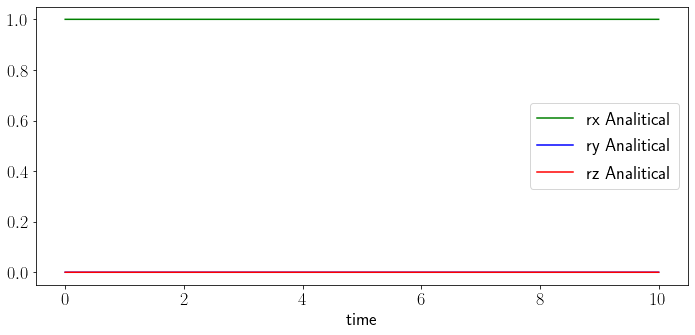

time: 882 ms


In [5]:
## Von Neumann evolution
anali = test.VonNeumannAnalitical()

# Von Neumann plot
rhoBlochrep(anali, t, r'Analitical', '-')
plt.tight_layout()

In [6]:
## Average conditional feedback evoltuion
average_feed = test.feedRhoAverage(n_trajectories = 500, method = 'euler', parallelfor = True)

Cpu cores available:  8
time: 6min 9s


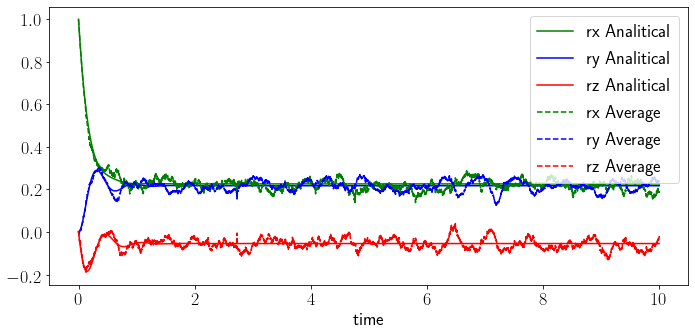

time: 1.76 s


In [7]:
# Anlitical unconditional feedback evolution
anali_feed = test.feedAnaliticalUncond(3, 1e-12, 1e-12)

# Feedback plot
rhoBlochrep(anali_feed, t, r'Analitical', '-')
rhoBlochrep(average_feed, t, r'Average', '--')
plt.tight_layout()

In [5]:
## Average conditional Qjump evoltuion
rho_qjump = test.jumpRhoAverage(1000, traj_type = 'vector', time_dep = False)

time: 5min 53s


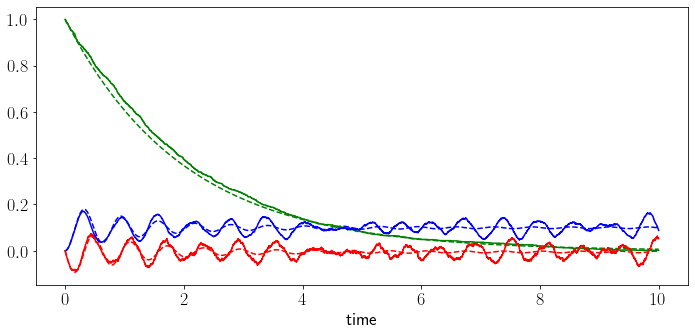

time: 1.15 s


In [6]:
# Anlitical unconditional Qjump evolution
rhoUana = test.lindbladAnalitical()

## Qjumps plot
rhoBlochrep(rhoUana, t, 'Analitical', '--')
rhoBlochrep(rho_qjump, t, 'Qjump', '-')
plt.tight_layout()
plt.show()

In [25]:
## Average conditional diffusive evoltuion
rho_diff = test.diffusiveRhoAverage(1, method = 'euler', parallelfor = True)

time: 10.9 s


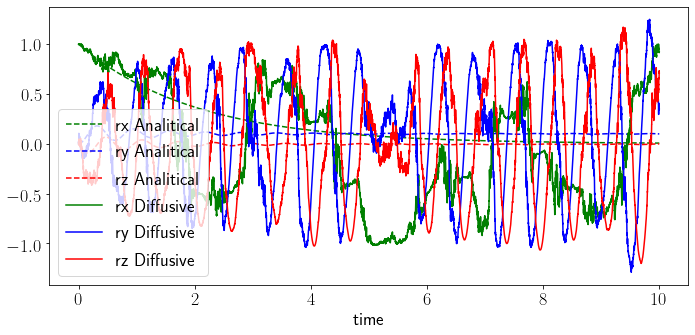

time: 1.45 s


In [26]:
# Anlitical unconditional diffusive evolution
rhoUana = test.lindbladAnalitical()

## Diffusive plot
rhoBlochrep(rhoUana, t, 'Analitical', '--')
rhoBlochrep(rho_diff, t, 'Diffusive', '-')
plt.tight_layout()
plt.show()

In [13]:
Y = test.current_Y(10)

time: 12.8 s


In [14]:
J = test.current_J(10)

time: 11.4 s


### Quantum jump connection to the diffusive unraveling

The Qjump methods are equiped with an unraveling option that allows us to explore the continous limit of the this scheme

In [15]:
## Large coherent field mu and small time step dt
mu = 10
steps = 50000
t = np.linspace(t0, tf, steps)

## u set the unraveling, u = 1 homodyne x quadrature, u = -1 homodyne y quadrature, u = 0 heterodyne of x and y qudratures
#u_matrix = 0.2*np.eye(len(L(0)))

h_matrix = np.eye(len(L()))

def u_matrix(t, rho):
    return np.array([[-np.trace(np.dot(rho,sigmam))/np.trace(np.dot(rho,sigmap))]])

## System class init
discrete_test = qtr.System(H0, psi0, t, lindbladList = L, uMatrix = u_matrix, HMatrix = h_matrix, FList = F, amp = [mu, mu])

Initial state is unnormalized. Normalized state taken instead
time: 8.28 ms


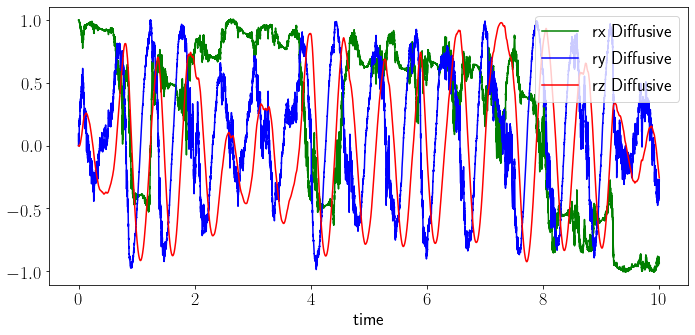

time: 1min 2s


In [17]:
## Diffusive trajectory
rho_diff = discrete_test.diffusiveRhoTrajectory(1, method = 1)

## Diffusive plot
rhoBlochrep(rho_diff, t, 'Diffusive', '-')
plt.tight_layout()
plt.show()

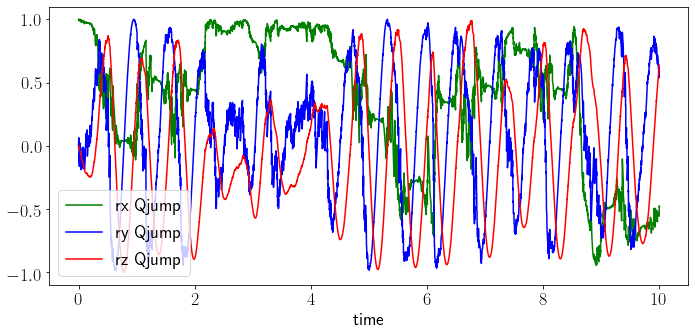

time: 1min 33s


In [18]:
## Qjump trajectory
rho_qjump = discrete_test.jumpRhoTrajectory(1, unraveling = True)

## Qjumps plot
rhoBlochrep(rho_qjump, t, 'Qjump', '-')
plt.tight_layout()
plt.show()